#Priyank D Gala
#B K Birla College of Arts, Science & Commerce

#Air Passengers Time Series Model

In [ ]:
#installing pdarima for our model
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.8 MB 4.3 MB/s 
     |████████████████████████████████| 9.9 MB 26.0 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.12.2
    Uninstalling statsmodels-0.12.2:
      Successfully uninstalled statsmodels-0.12.2


##1 Reading and getting details of Dataset

In [ ]:
#importing all necessaary modules
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

import seaborn as sns
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima.arima import auto_arima
from datetime import datetime

from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

import warnings
warnings.filterwarnings('ignore')

In [ ]:
#Reading the dataset
df = pd.read_csv('/content/AirPassengers.csv', index_col=['Month'], date_parser=lambda dates: pd.datetime.strptime(dates, '%Y-%m'), parse_dates=['Month'])
df.head()

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [ ]:
df.index #verifying the index

DatetimeIndex(['1949-01-01', '1949-02-01', '1949-03-01', '1949-04-01',
               '1949-05-01', '1949-06-01', '1949-07-01', '1949-08-01',
               '1949-09-01', '1949-10-01',
               ...
               '1960-03-01', '1960-04-01', '1960-05-01', '1960-06-01',
               '1960-07-01', '1960-08-01', '1960-09-01', '1960-10-01',
               '1960-11-01', '1960-12-01'],
              dtype='datetime64[ns]', name='Month', length=144, freq=None)

In [ ]:
#Checking passengers at each month
ts = df['Passengers']
ts

Month
1949-01-01    112
1949-02-01    118
1949-03-01    132
1949-04-01    129
1949-05-01    121
             ... 
1960-08-01    606
1960-09-01    508
1960-10-01    461
1960-11-01    390
1960-12-01    432
Name: Passengers, Length: 144, dtype: int64

In [ ]:
ts[:'1949-05-01']

Month
1949-01-01    112
1949-02-01    118
1949-03-01    132
1949-04-01    129
1949-05-01    121
Name: Passengers, dtype: int64

In [ ]:
#Creating a sample data and grouping it by year
df['Year'] = df.index.year
m = df.groupby('Year').mean()
m

,#Passengers
Year,
1949,126.666667
1950,139.666667
1951,170.166667
1952,197.000000
1953,225.000000
1954,238.916667
1955,284.000000
1956,328.250000
1957,368.416667


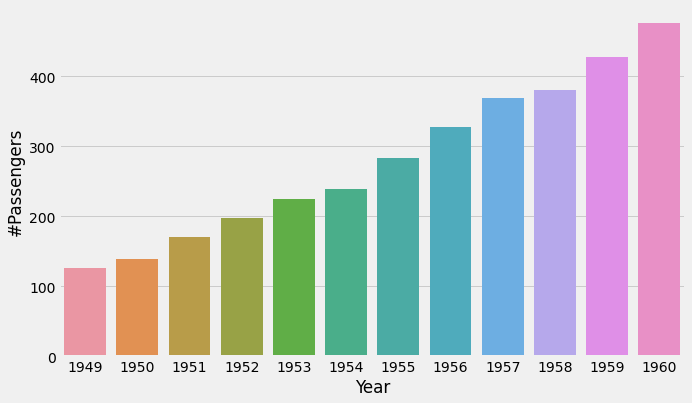

In [ ]:
#Using Seaborn to plot mean amount of passengers over the years
sns.barplot(data=m, y='#Passengers', x=m.index)

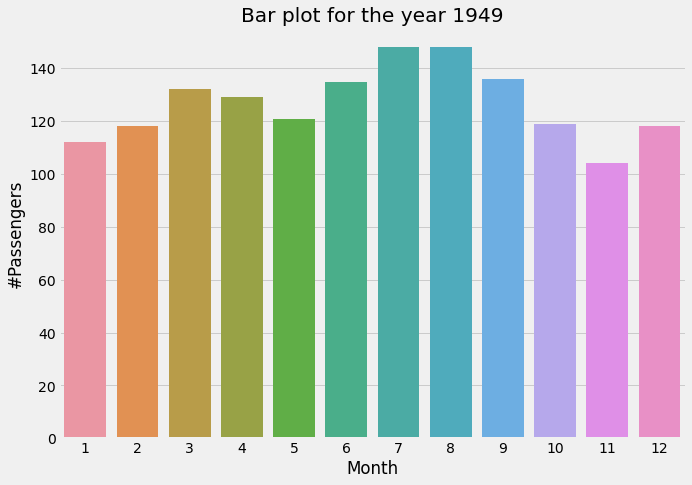

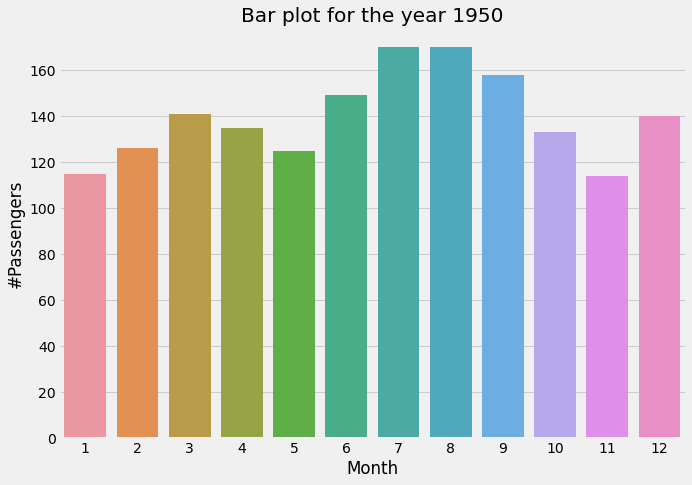

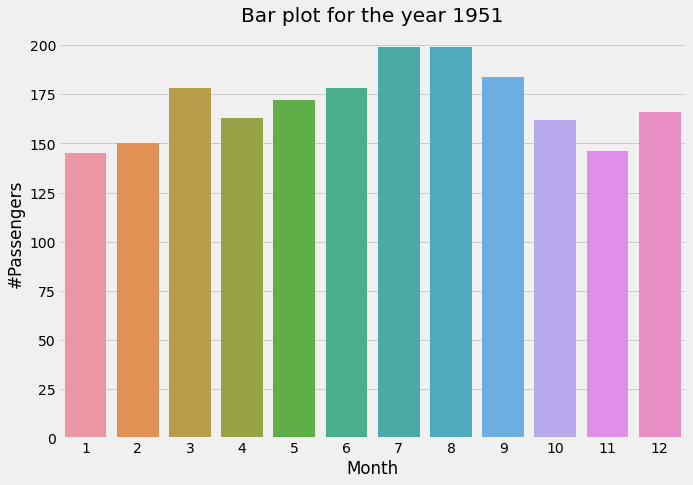

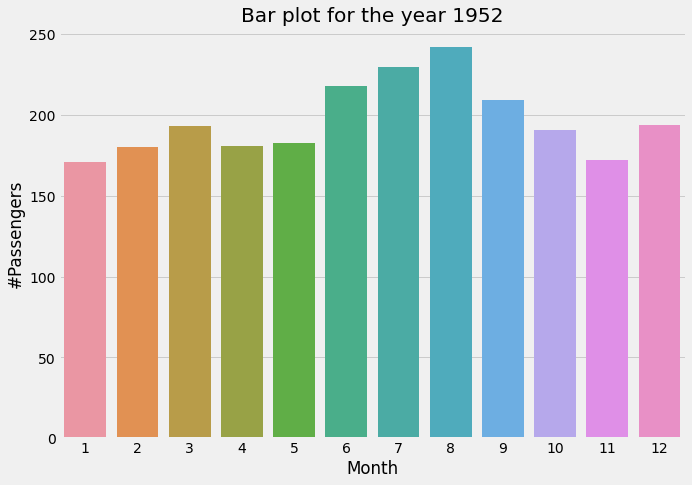

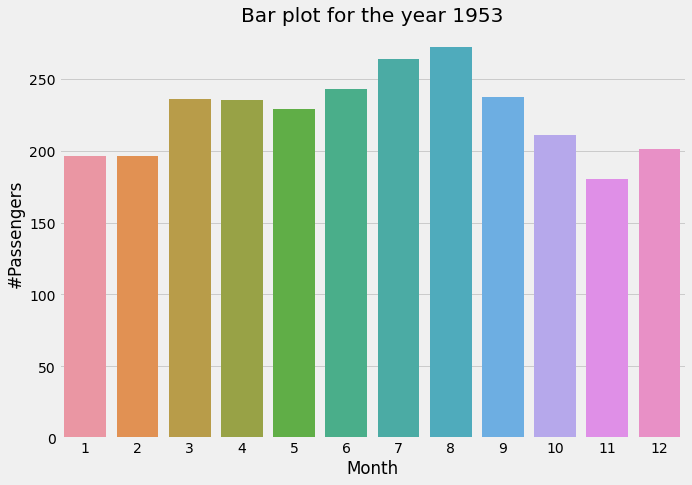

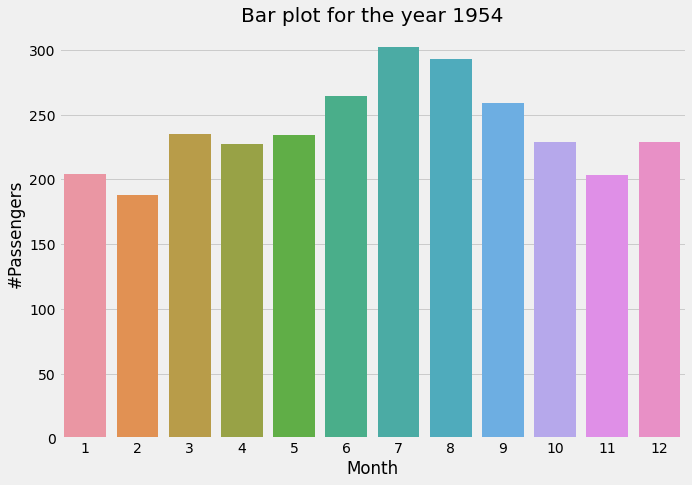

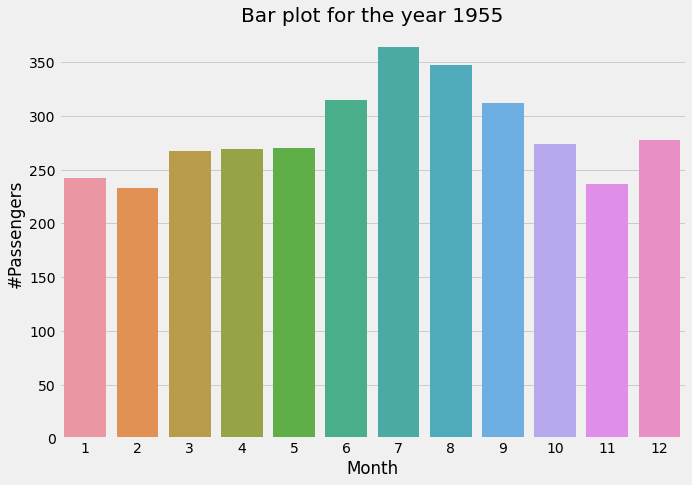

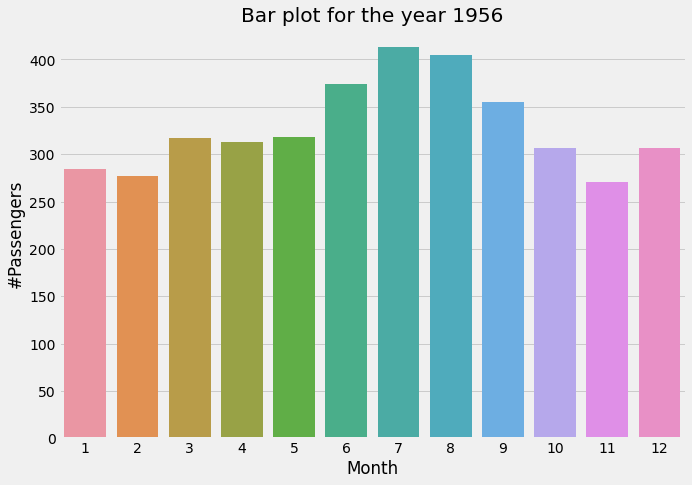

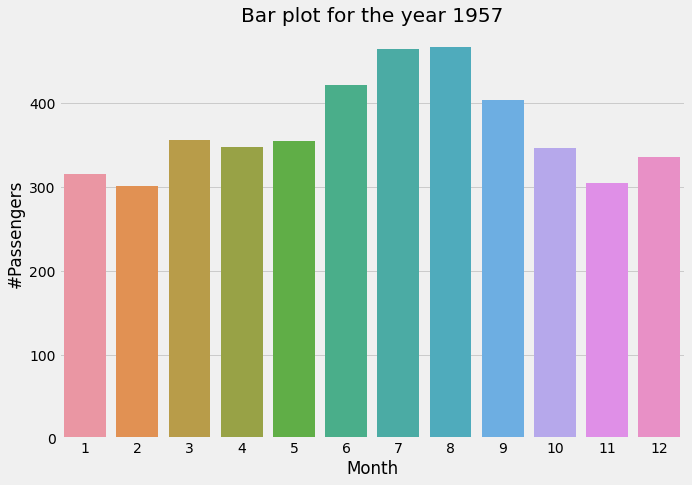

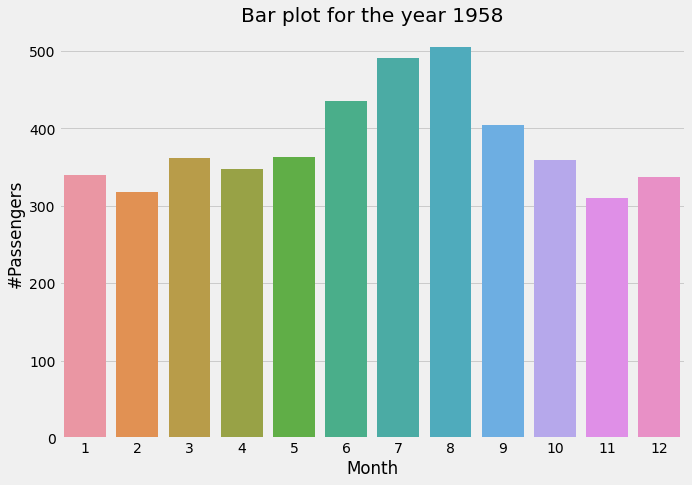

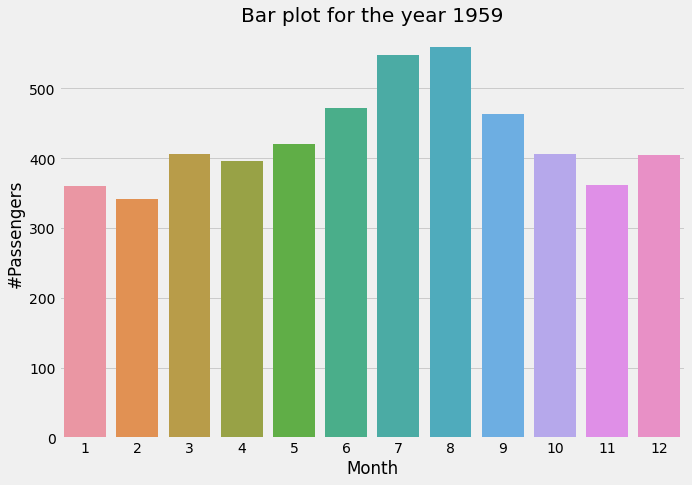

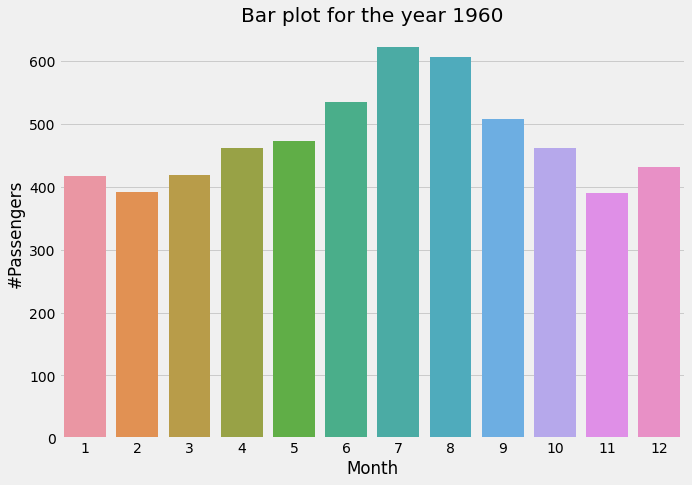

In [ ]:
#Printing passengers per year for every month
for i in range(12):
    plt.figure(figsize=(10,100))
    plt.subplot(12,1,i+1)
    sns.barplot(data= df.iloc[12*i:12*(i+1)], x=df.iloc[12*i:12*(i+1)].index.month, y='#Passengers')
    plt.title(f'Bar plot for the year {1949+i}')

In [ ]:
df.columns = ['Passengers', 'Year'] # To ease the writing we change the name of the passenger column

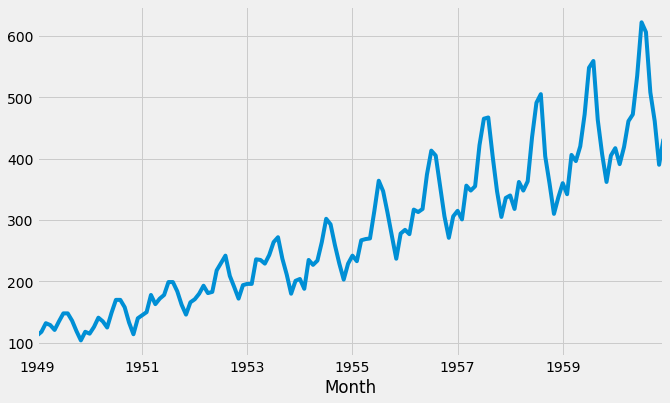

In [ ]:
df.Passengers.plot(kind='line')

In [ ]:
df.describe()

,Passengers,Year
count,144.000000,144.000000
mean,280.298611,1954.500000
std,119.966317,3.464102
min,104.000000,1949.000000
25%,180.000000,1951.750000
50%,265.500000,1954.500000
75%,360.500000,1957.250000
max,622.000000,1960.000000


##2 Stationary Checking

In [ ]:
#Test for staionarity
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)

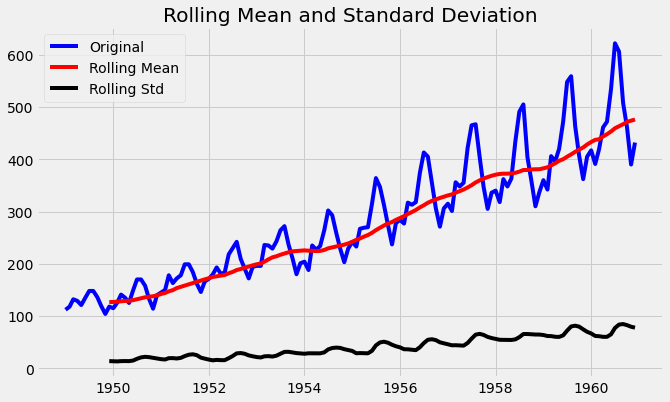

Results of dickey fuller test
Test Statistics                  0.815369
p-value                          0.991880
No. of lags used                13.000000
Number of observations used    130.000000
critical value (1%)             -3.481682
critical value (5%)             -2.884042
critical value (10%)            -2.578770
dtype: float64


In [ ]:
test_stationarity(df.Passengers)

<Figure size 720x432 with 0 Axes>

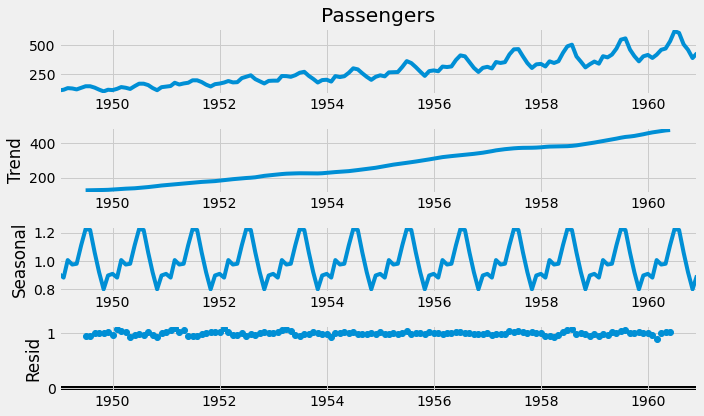

In [ ]:
#The p-Value and comparision of test statistics with critical values concludes that the series is not stationary, as expected.
#Let us separate Trend and Seasonality from the series.

result = seasonal_decompose(df.Passengers, model='multiplicative')
fig = plt.figure()  
fig = result.plot() 

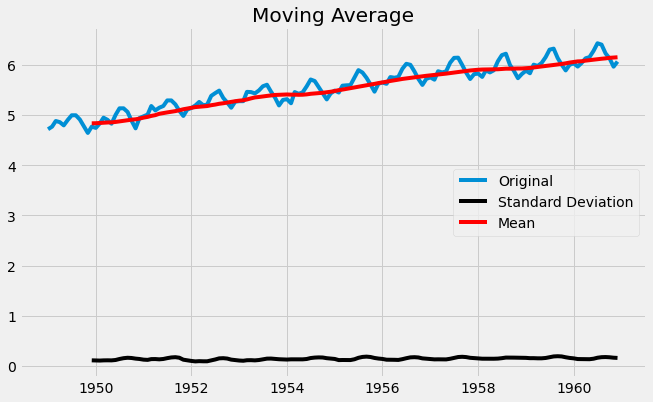

In [ ]:
#plotting to know the moving average of passengers
df_log = np.log(df.Passengers)
moving_avg = df_log.rolling(12).mean()
std_dev = df_log.rolling(12).std()
plt.legend(loc='best')
plt.title('Moving Average')
plt.plot(df_log, label='Original')
plt.plot(std_dev, color ="black", label = "Standard Deviation")
plt.plot(moving_avg, color="red", label = "Mean")
plt.legend()

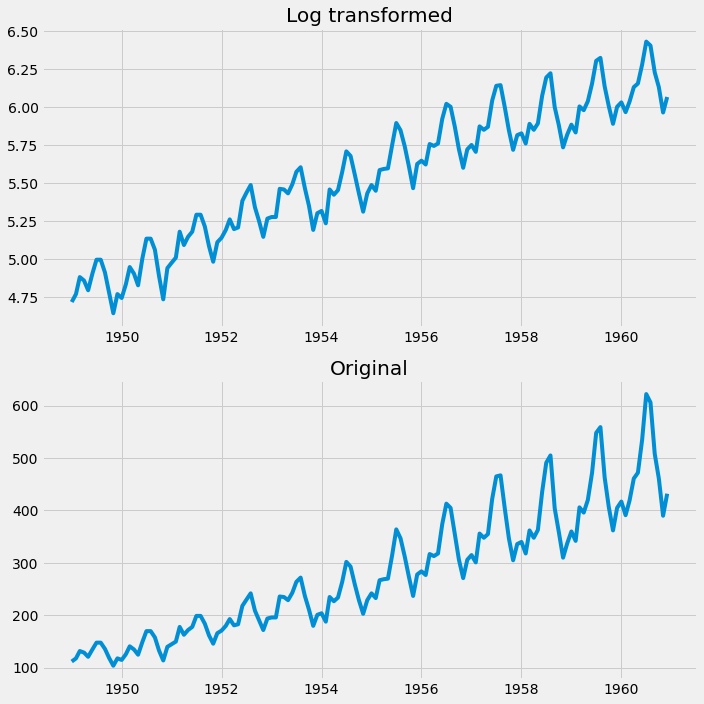

In [ ]:
#log transformation forecasting
plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
plt.plot(df_log)
plt.title('Log transformed')
plt.subplot(2,1,2)
plt.plot(df.Passengers)
plt.title('Original')
plt.tight_layout()

##3 ARIMA and SARIMAX Model

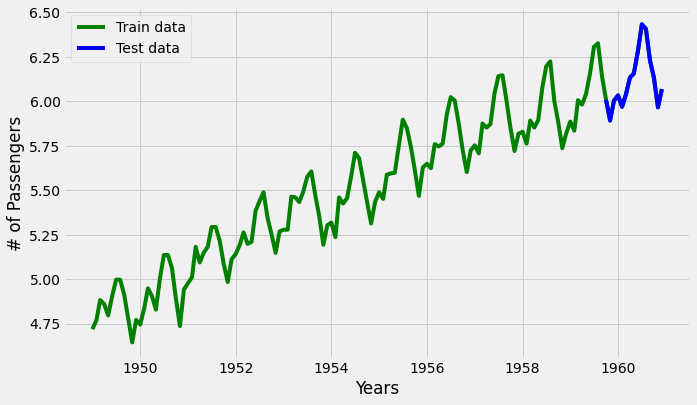

In [ ]:
#split data into train and training set
train_data, test_data = df_log[:int(len(df_log)*0.9)], df_log[int(len(df_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Years')
plt.ylabel('# of Passengers')
plt.plot(df_log, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,1)[12] intercept   : AIC=inf, Time=0.54 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=141.762, Time=0.11 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=inf, Time=1.22 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=inf, Time=1.16 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=807.483, Time=0.02 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : AIC=inf, Time=0.52 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : AIC=inf, Time=0.73 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=-204.195, Time=0.16 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=-294.073, Time=0.49 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=-428.595, Time=0.77 sec
 ARIMA(1,0,0)(2,0,1)[12] intercept   : AIC=-424.568, Time=3.82 sec
 ARIMA(1,0,0)(1,0,2)[12] intercept   : AIC=-425.703, Time=2.11 sec
 ARIMA(1,0,0)(0,0,2)[12] intercept   : AIC=-331.961, Time=0.63 sec
 ARIMA(1,0,0)(2,0,0)[12] intercept   : AIC=inf, Time=1.46 sec
 ARIMA(1,0,0)(2,0,2)[12] intercept   : AIC=inf, Tim

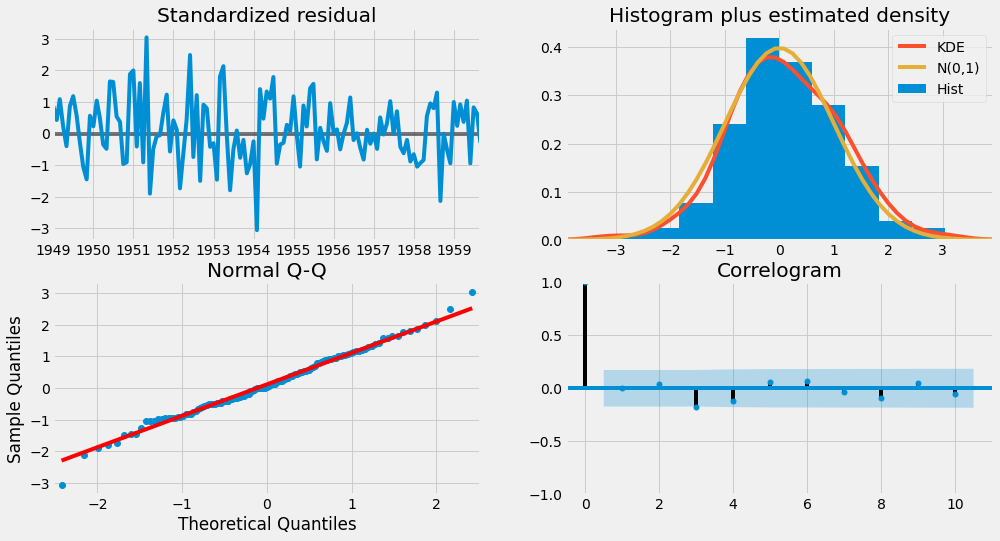

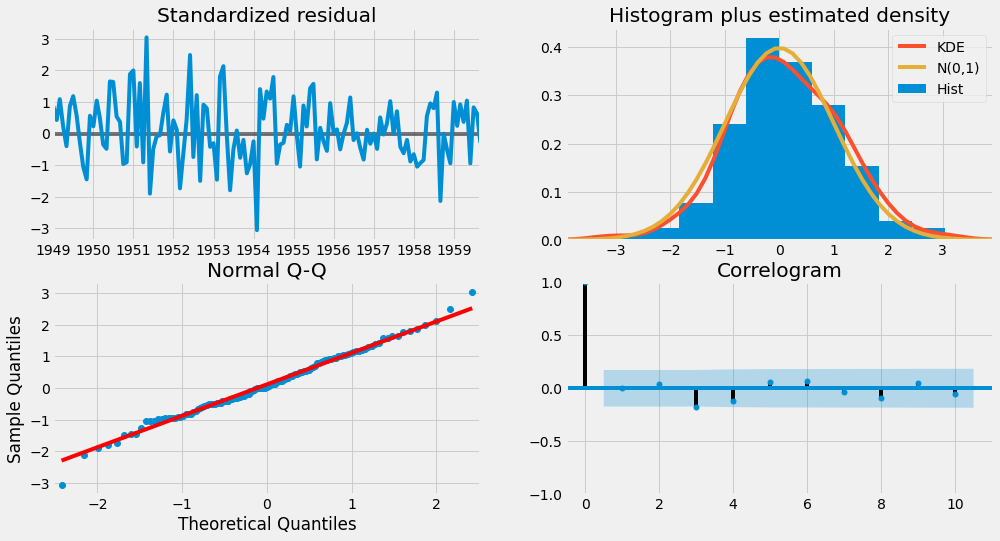

In [ ]:
model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=12,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=True,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      n_jobs=-1,
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA.summary())
model_autoARIMA.plot_diagnostics(figsize=(15,8))

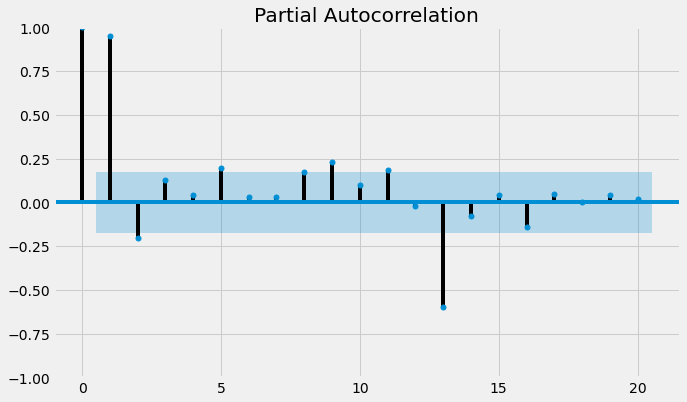

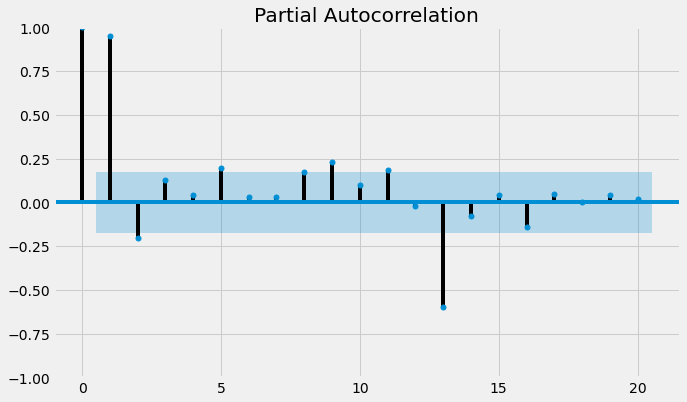

In [ ]:
#We have no idea why it is plotting the same plot twice. Plot seem all great so let us model now and predict.

plot_pacf(train_data, lags=20)

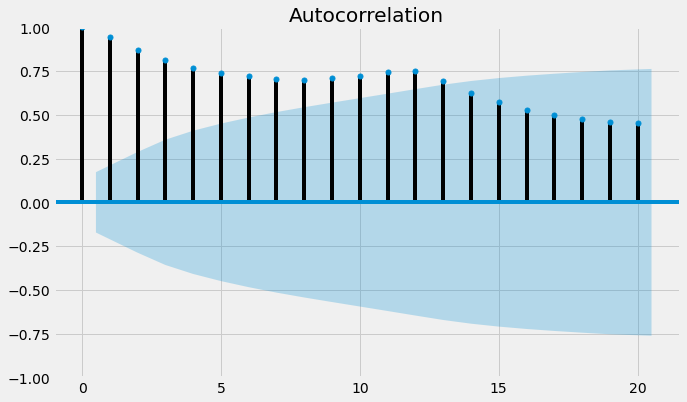

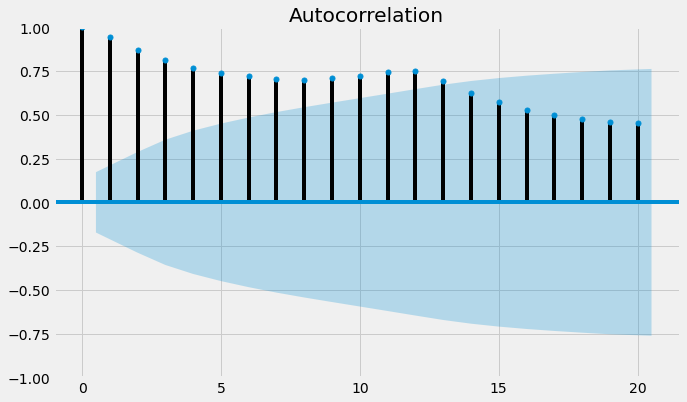

In [ ]:
#So that tells p=1 seem to be right choice.

plot_acf(train_data,lags=20)

ACF seem to be geometric. Though to determine these parameters we will use autoarima.

#4 Building Model

In [ ]:
# Build Model
model = ARIMA(train_data, order=(1,0,1), seasonal_order=(1,0,1,12))  
fitted = model.fit()  
print(fitted.summary())

                                    SARIMAX Results                                     
Dep. Variable:                       Passengers   No. Observations:                  129
Model:             ARIMA(1, 0, 1)x(1, 0, 1, 12)   Log Likelihood                 224.297
Date:                          Mon, 21 Nov 2022   AIC                           -436.594
Time:                                  14:37:02   BIC                           -419.435
Sample:                              01-01-1949   HQIC                          -429.622
                                   - 09-01-1959                                         
Covariance Type:                            opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.1919     22.302      0.233      0.816     -38.519      48.903
ar.L1          0.9891      0.024     40.627      0.

In [ ]:
#Model seem to be doing an excellent job :)

mse = mean_squared_error(test_data, fc)
print('MSE: '+str(mse))
mae = mean_absolute_error(test_data, fc)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(test_data, fc))
print('RMSE: '+str(rmse))
mape = np.mean(np.abs(fc - test_data)/np.abs(test_data))
print('MAPE: '+str(mape))

MSE: 0.0013819167311248238
MAE: 0.03253396523019975
RMSE: 0.03717414062389101
MAPE: 0.005304242776039099


In [ ]:
# Forecast
fc = fitted.forecast(len(test_data))  # 95% conf

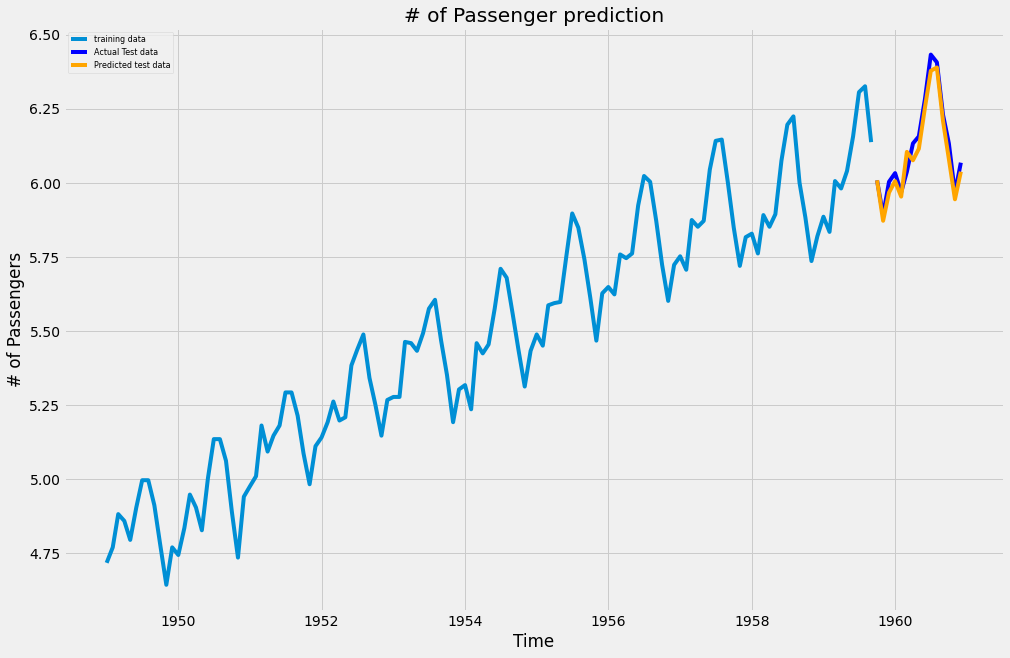

In [ ]:
fc_series = pd.Series(fc, index=test_data.index)

plt.figure(figsize=(15,10))
plt.plot(train_data, label='training data')
plt.plot(test_data, color = 'blue', label='Actual Test data')
plt.plot(fc_series, color = 'orange',label='Predicted test data')

plt.title('# of Passenger prediction')
plt.xlabel('Time')
plt.ylabel('# of Passengers')
plt.legend(loc='upper left', fontsize=8)